In [37]:
# IMPORTS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

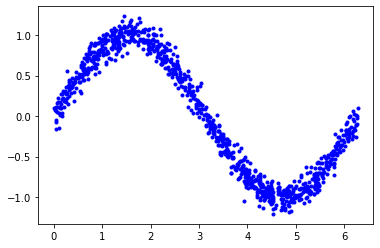

In [38]:
# CREATE DATA
NUM_SAMPLES = 1000

# Any number would do
SEED = 2345
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Uniformly distributed number between 0 to 2pi
x_vals = np.random.uniform(low=0, high=2*math.pi, size=NUM_SAMPLES)
np.random.shuffle(x_vals)

# The secret formula
y_vals = np.sin(x_vals)

# Scatter the value a bit
y_vals += 0.1 * np.random.randn(y_vals.size)

# Plot data
plt.plot(x_vals, y_vals, 'b.')
plt.show()

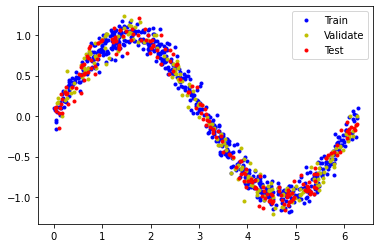

In [39]:
# Splits raw data for training
def split_data(vals, pos1, pos2):
  assert(pos1 + pos2 <= 1.0)
  TRAIN_SPLIT = int(pos1 * vals.size)
  TEST_SPLIT = int(TRAIN_SPLIT + pos2 * vals.size)
  train, test, validate = np.split(vals, [TRAIN_SPLIT, TEST_SPLIT])
  assert(train.size + test.size + validate.size == vals.size)
  return train, validate, test

# 60/20/20 split
x_train, x_validate, x_test = split_data(x_vals, 0.6, 0.2)
y_train, y_validate, y_test = split_data(y_vals, 0.6, 0.2)

# Plot
plt.plot(x_train, y_train, 'b.', label='Train')
plt.plot(x_validate, y_validate, 'y.', label='Validate')
plt.plot(x_test, y_test, 'r.', label='Test')
plt.legend()
plt.show()

In [40]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model_1.add(layers.Dense(1))
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                32        
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [41]:
# TRAINING
history_1 = model_1.fit(x_train, y_train, epochs=600, batch_size=32, validation_data=(x_validate, y_validate))

Epoch 1/600
19/19 [==============================] - 1s 8ms/step - loss: 1.1862 - mae: 0.9252 - val_loss: 0.7050 - val_mae: 0.7712
Epoch 2/600
19/19 [==============================] - 0s 3ms/step - loss: 0.5426 - mae: 0.6650 - val_loss: 0.4181 - val_mae: 0.5630
Epoch 3/600
19/19 [==============================] - 0s 4ms/step - loss: 0.4214 - mae: 0.5627 - val_loss: 0.3529 - val_mae: 0.5124
Epoch 4/600
19/19 [==============================] - 0s 2ms/step - loss: 0.3704 - mae: 0.5246 - val_loss: 0.3145 - val_mae: 0.4847
Epoch 5/600
19/19 [==============================] - 0s 2ms/step - loss: 0.3252 - mae: 0.4931 - val_loss: 0.2731 - val_mae: 0.4426
Epoch 6/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2855 - mae: 0.4603 - val_loss: 0.2573 - val_mae: 0.4422
Epoch 7/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2528 - mae: 0.4346 - val_loss: 0.2120 - val_mae: 0.3954
Epoch 8/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2222 - m

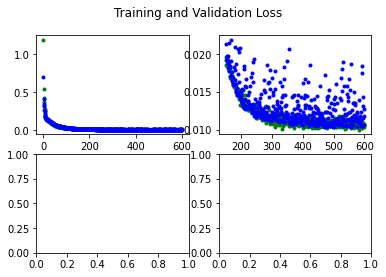

In [42]:
# TRAIN RESULT VISUALIZATION
fig, [[g1, g2], [g3, g4]] = plt.subplots(2, 2)
fig.suptitle('Training and Validation Loss')

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

# All
g1.plot(epochs, loss, 'g.', label='Training loss')
g1.plot(epochs, val_loss, 'b.', label='Validation loss')
# Skip first part
SKIP = 150
g2.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
g2.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.show()

mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
# All
g3.plot(epochs, mae, 'g.', label='MAE')
g3.plot(epochs, val_mae, 'b.', label='Validation MAE')
# Skip first part
g4.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
g4.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')

fig.legend()
plt.show()

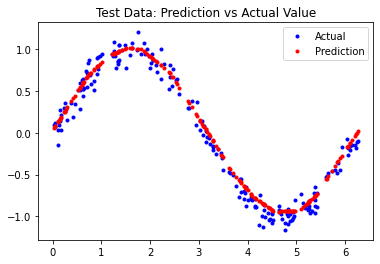

In [43]:
# MAKE PREDICTION
pred = model_1.predict(x_test)
plt.clf()
plt.title('Test Data: Prediction vs Actual Value')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, pred, 'r.', label='Prediction')
plt.legend()
plt.show()

In [45]:
# CONVERT TO TENSORFLOW LIGHT FORMAT
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()
open("sine-model.tflite", "wb").write(tflite_model)

# CONVERT WITH QUANTIZATION
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
  for v in x_test:
    # each scalar value must be inside a 2D array
    yield [np.array(v, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator
tflite_model_quantized = converter.convert()
open("sine-model-quantized.tflite", "wb").write(tflite_model_quantized)


INFO:tensorflow:Assets written to: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmpvwo725sf/assets


INFO:tensorflow:Assets written to: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmpvwo725sf/assets
2022-03-20 19:40:41.165903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-20 19:40:41.165921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-20 19:40:41.166204: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmpvwo725sf
2022-03-20 19:40:41.167922: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-20 19:40:41.167941: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmpvwo725sf
2022-03-20 19:40:41.173427: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-20 19:40:41.227850: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

INFO:tensorflow:Assets written to: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmp5qb_p679/assets


INFO:tensorflow:Assets written to: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmp5qb_p679/assets
/Users/dannywidjaya/Projects/Arduino/Sketches/hello-nano-33/model/venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-03-20 19:40:42.326995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-20 19:40:42.327011: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-20 19:40:42.327140: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gl/7wqtc3m93rx5gvvnccm34dmw0000gn/T/tmp5qb_p679
2022-03-20 19:40:42.328719: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-20 19:40:42.328784: I tensorflow/cc/saved_model/reader.c

2776

In [47]:
# CREATE TENSORFLOW LITE MODELS FROM THE FILES
def load_and_run_tflite(filename):
  model = tf.lite.Interpreter(filename)
  model.allocate_tensors()
  model_input_index = model.get_input_details()[0]["index"]
  model_output_index = model.get_output_details()[0]["index"]

  model_predictions = []
  for x in x_test:
    x_value_tensors = tf.convert_to_tensor([[x]], dtype=np.float32)
    model.set_tensor(model_input_index, x_value_tensors)
    model.invoke()
    model_predictions.append(model.get_tensor(model_output_index)[0])

  plt.clf()
  plt.title("Comparison")
  plt.plot(x_test, y_test, "bo", label="Actual")
  plt.plot(x_test, pred, "ro", label="Original Predictions")
  plt.plot(x_test, model_predictions, "gx", label="TFLite Predictions")
  plt.legend()
  plt.show


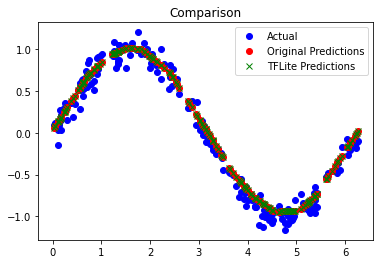

In [48]:
load_and_run_tflite("sine-model.tflite")

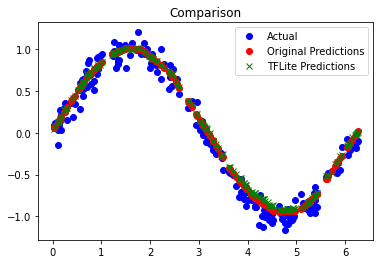

In [49]:
load_and_run_tflite("sine-model-quantized.tflite")

In [50]:
# COMPARE MODEL SIZES
import os
basic_model_size = os.path.getsize("sine-model.tflite")
quantized_model_size = os.path.getsize("sine-model-quantized.tflite")
print(f"Size: basic {basic_model_size} bytes, quantized {quantized_model_size} bytes")
print(f"Difference: {basic_model_size - quantized_model_size} bytes")

Size: basic 2960 bytes, quantized 2776 bytes
Difference: 184 bytes


In [52]:
# SAVE FILE AS C SOURCE FILE
!xxd -i sine-model-quantized.tflite > sine-model-quantized.cpp
!xxd -i sine-model.tflite > sine-model.cpp